# Product Detection in Grocerry Shops Shelves

### Problem Statement - Given a grocery shop image we have to detect which part of image contains the product and how many product contains in the image , we show the product by using the bounding boxes

### Dataset overview:
### Data Form : JPG Image Files
#### Using the data from :https://github.com/gulvarol/grocerydataset#shelfimages
#### features - Images of shelves from grocerry stores
#### ground truth : annotations of image
### image properties:
The naming is as follows:

			"C<c>_P<p>_N<n>_S<s>_<i>.JPG"
			where
				<c> := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
				<p> := planogram id
				<n> := the rank of the top shelf on the image according to the planogram
				<s> := number of shelves on the image
				<i> := copy number

# Exploratory Data Analysis

In [3]:
# references : https://www.kaggle.com/jpmiller/basic-eda-with-images
import numpy as np
import pandas as pd
import os
import random
import cv2
#import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from dask import bag, diagnostics

In [5]:
# number of data points in the data
path="C:/Users/Karan/Desktop/grocery dataset/ShelfImages/"
files=os.listdir(path)
print("Number of Data Points:" , len(files))

Number of Data Points: 354


In [6]:
# splitting 0.8*354 
from random import sample 
train_row_count = int(0.8*354)
train_file_names = random.sample( files ,train_row_count )
test_file_names =  list( set(files) - set(train_file_names) )

In [7]:
print("train_row_count : " , len(train_file_names))
print("test_row_count : " , len(test_file_names))

train_row_count :  283
test_row_count :  71


### Printing Random Image from data

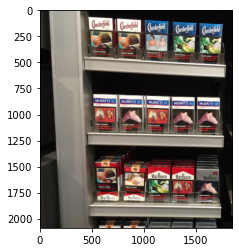

In [145]:
files=os.listdir(path)
image_name=random.choice(train_file_names)
img=mpimg.imread(path + image_name)
imgplot = plt.imshow(img)

## Drawing Bounding Box at random image

Number of Products: 15


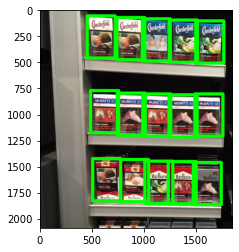

In [148]:
import cv2
f = open("C:/Users/Karan/Desktop/grocery dataset/annotations_shelves.txt", "r")
annot = []
for i in f:
    if i.split()[0] == image_name:
            annot = i.split()[2:]
            break

color = (0, 255,0 ) 
thickness = 30
print("Number of Products:" , len(annot)//5)

for i in range(0,len(annot) , 5):
    x = int(annot[i])
    y = int(annot[i+1])
    w = int(annot[i+2])
    h = int(annot[i+3])
    b = annot[i+4]
    img = cv2.rectangle(img ,(x,y) , (x+w , y+h) ,color , thickness)
imgplot = plt.imshow(img)

## Average Number of Shelve in Image

In [30]:
shelve_counts = []
for i in train_file_names:
    count = int(i.split('_')[-2][1:])
    shelve_counts.append(count)
    
print("Average Number of Shelves in Image" , sum(shelve_counts)/len(shelve_counts))

Average Number of Shelves in Image 3.2720848056537104


## Histogram of Number of Shelve

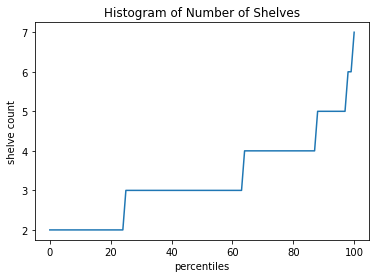

In [47]:
import matplotlib.pyplot as plt
percentiles = [np.percentile(shelve_counts,i) for i in range(0,101 , 1)]
plt.plot(range(0,101,1) , percentiles)
plt.title("Histogram of Number of Shelves")
plt.xlabel("percentiles")
plt.ylabel("shelve count")
plt.show()

## Average Number of Products in Image

In [56]:
products_count = []
f = open("C:/Users/Karan/Desktop/grocery dataset/annotations_shelves.txt", "r")

for i in f:
    number = int(i.split()[1])
    products_count.append(number)

print("Average Number of Products in Image" , sum(products_count)/len(products_count))

Average Number of Products in Image 37.24293785310734


## Histogram of Number of Products

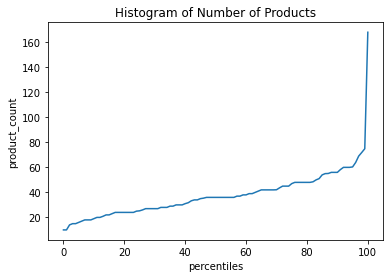

In [57]:
import matplotlib.pyplot as plt
percentiles = [np.percentile(products_count,i) for i in range(0,101 , 1)]
plt.plot(range(0,101,1) , percentiles)
plt.title("Histogram of Number of Products")
plt.xlabel("percentiles")
plt.ylabel("product_count")
plt.show()

## Number of images Captured using each Camera

In [62]:
cameras_dict = {1:0 , 2:0 , 3:0 , 4:0}
for i in train_file_names:
    id = int( i.split('_')[ 0 ][ 1: ] )
    cameras_dict[id] += 1

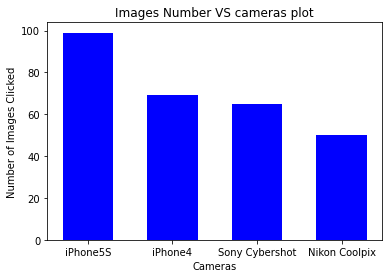

In [69]:
plt.title("Images Number VS cameras plot")
plt.ylabel("Number of Images Clicked")
plt.xlabel("Cameras")
plt.bar(['iPhone5S', 'iPhone4','Sony Cybershot','Nikon Coolpix']  ,cameras_dict.values(), color ='blue',  
        width = 0.6)
plt.show()

## Getting interactive Density of Dimensions plot

In [23]:
# get image dimensions
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    print(file)
    return h,w

# parallelize
filepath = path
filelist = [filepath + f for f in train_file_names]
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

[########################################] | 100% Completed |  9.8s


:Scatter   [height]   (width,count)

## Observations:
* Average Number of Shelve is around 3
* less than 90% of the images have less than or equal to 4 shelves
* Average Number of Products in Image 37.24293785310734
* less than 99% of images have less than 80 products in images
* iphone 5 has the largest number of image captures than any device
* there is a very large variance in the height and width of images

# Creating Input PipeLine

In [ ]:
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install opencv-python
!pip install tensorflow

In [ ]:
%cd /content/drive/MyDrive/tf2/
!git clone https://github.com/tensorflow/models/
%cd /content/drive/My Drive/tf2/models/research/object_detection

In [8]:
!mkdir trainin
!mkdir inference_graph
!mkdir -p images\train
!mkdir -p images\test

In [5]:
%cd /content/drive/My Drive/tf2/

/content/drive/My Drive/tf2/


## Moving All image Files to train and Test Folder
* Move the Train Images to Images/train
* Move the test Images to Images/test

In [11]:
import glob
import os
import shutil
trainset = train_file_names.copy()
testset = test_file_names.copy()
i = 0
path = "ShelfImages/"
for fileName in trainset + testset:
  if fileName in trainset:
    shutil.copyfile(path+fileName ,"/models/research/object_detection/images/train/" + fileName)
  else:
    shutil.copyfile(path+fileName ,"/models/research/object_detection/images/test/" + fileName)

## Creating the train_labels and test_labels
* First We will create a dictionary where keys will be image and values will be annotations
* Create train_labels.csv and test_labels.csv containing the Below columns:
<br>
filename' , 'width' , 'class'  , 'height' , 'xmin' , 'xmax' , 'ymin'  , 'ymax'

In [ ]:
f = open("annotations_shelves.txt", "r")
annotations_dict = {}
for i in f:
    file_name = i.split()[0]
    rest = i.split()[2:]
    annotations_dict[file_name] = rest

In [13]:
import pandas as pd
## for Training Set
di_train = {'filename':[] , 'width':[] , 'class':[]  , 'height':[] , 'xmin':[] , 'xmax':[] , 'ymin':[]  , 'ymax':[] }
for fname in trainset:
    for i in range(0, len(annotations_dict[fname]) , 5):
        x = annotations_dict[fname][i] ; y = annotations_dict[fname][i + 1] 
        
        w = annotations_dict[fname][i + 2] ; h = annotations_dict[fname][i + 3]
        
        x = int(x); y = int(y) ; w = int(w) ; h = int(h)
        
        di_train['filename'].append(fname)
        di_train['width'].append(w)
        di_train['class'].append("Product")
        di_train['height'].append(h)
        di_train['xmin'].append(x)
        
        di_train['xmax'].append(x+w)
        di_train['ymin'].append(y)
        di_train['ymax'].append(y+h)
        
df_train = pd.DataFrame(di_train)
df_train.to_csv("models/research/object_detection/images/train_labels.csv")

di_test = {'filename':[] , 'width':[] , 'class':[]  , 'height':[] , 'xmin':[] , 'xmax':[] , 'ymin':[]  , 'ymax':[] }

for fname in testset:
    for i in range(0, len(annotations_dict[fname]) , 5):
        x = annotations_dict[fname][i] ; y = annotations_dict[fname][i + 1] 
        w = annotations_dict[fname][i + 2] ; h = annotations_dict[fname][i + 3]
        x = int(x); y = int(y) ; w = int(w) ; h = int(h)
        
        di_test['filename'].append(fname)
        di_test['width'].append(w)
        di_test['class'].append("Product")
        di_test['height'].append(h)
        di_test['xmin'].append(x)
        di_test['xmax'].append(x+w)
        di_test['ymin'].append(y)
        di_test['ymax'].append(y+h)

df_test = pd.DataFrame(di_test)

df_test.to_csv("models/research/object_detection/images/test_labels.csv")

## Creating the tf records file from images and annotations
* We will be creating train.record and test.record

In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

def class_text_to_int(row_label):
    if row_label == 'Product':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))
        
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example


def main():
    for item in ['test', 'train']:
      output_path = "/models/research/object_detection/{}.record".format(item)
      writer = tf.io.TFRecordWriter(output_path)
      path = os.path.join("/models/research/object_detection/", "images/{}".format(item))
      examples = pd.read_csv("/models/research/object_detection/images/{}_labels.csv".format(item))
      grouped = split(examples, 'filename')
      for group in grouped:
          tf_example = create_tf_example(group, path)
          writer.write(tf_example.SerializeToString())

      writer.close()
      output_path = os.path.join(os.getcwd(), output_path)
      print('Successfully created the TFRecords: {}'.format(output_path))

main()

Successfully created the TFRecords:/models/research/object_detection/test.record
Successfully created the TFRecords: /models/research/object_detection/train.record


## Creating the  labelmap

In [ ]:
%%writefile /models/research/object_detection/training/labelmap.pbtxt
item {
  id: 1
  name: 'Product'
}